## Keras model

### Implement the one from Keras website
#### Uses only playtime data

In [1]:
%pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 5.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 9.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 5.9 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 13.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [27]:
# import our processed datasets
users_df = pd.read_csv('../data/steam_playtime_clean.csv')
game_df = pickle.load(open('../data/steam_games_clean.pkl', 'rb'))

### Set up user data

In [3]:
users_df.head()

,appid,steam_id,playtime_forever
0,300,76561198015529005,90
1,340,76561198015529005,45
2,10180,76561198015529005,1406
3,10180,76561198015529005,17051
4,550,76561198015529005,349


In [4]:
len(users_df['steam_id'].unique())

19643

In [5]:
user_ids = users_df['steam_id'].unique().tolist()

In [6]:
user2user_encoded = {x: i for i, x in enumerate(user_ids)}

In [7]:
userencoded2user = {i: x for i, x in enumerate(user_ids)}

In [8]:
game_ids = users_df['appid'].unique().tolist()

In [9]:
game2game_encoded = {x: i for i, x in enumerate(game_ids)}

In [10]:
game_encoded2game = {i: x for i, x in enumerate(game_ids)}

In [11]:
users_df['user'] = users_df['steam_id'].map(user2user_encoded)

In [12]:
users_df['game'] = users_df['appid'].map(game2game_encoded)

In [13]:
num_users = len(user2user_encoded)
num_games = len(game_encoded2game)

In [14]:
users_df['playtime_forever'] = users_df['playtime_forever'].values.astype(np.float32)

In [15]:
min_playtime = min(users_df['playtime_forever'])
max_playtime = max(users_df['playtime_forever'])

In [16]:
print(
    "Number of users: {}, Number of Games: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_games, min_playtime, max_playtime
    )
)

Number of users: 19643, Number of Games: 19818, Min rating: 11.0, Max rating: 129957.0


In [44]:
users_df = users_df.sample(frac=1, random_state=42)
x = users_df[["user", "game"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = users_df["playtime_forever"].apply(lambda x: (x - min_playtime) / (max_playtime - min_playtime)).values

# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * users_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

KeyError: "None of [Index(['user', 'game'], dtype='object')] are in the [columns]"

Set up recommender net

In [19]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_games, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_games = num_games
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.game_embedding = layers.Embedding(
            num_games,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.game_bias = layers.Embedding(num_games, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        game_vector = self.game_embedding(inputs[:, 1])
        game_bias = self.game_bias(inputs[:, 1])
        dot_user_game = tf.tensordot(user_vector, game_vector, 2)
        # Add all the components (including bias)
        x = dot_user_game + user_bias + game_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_games, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)


2023-04-03 16:00:42.757236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-03 16:00:42.757755: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [42]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/5


ValueError: in user code:

    File "/home/berry/Lighthouse/Projects/video-game-recommender-v1/vgenv/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/berry/Lighthouse/Projects/video-game-recommender-v1/vgenv/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/berry/Lighthouse/Projects/video-game-recommender-v1/vgenv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/berry/Lighthouse/Projects/video-game-recommender-v1/vgenv/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/berry/Lighthouse/Projects/video-game-recommender-v1/vgenv/lib/python3.9/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/home/berry/Lighthouse/Projects/video-game-recommender-v1/vgenv/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/berry/Lighthouse/Projects/video-game-recommender-v1/vgenv/lib/python3.9/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/berry/Lighthouse/Projects/video-game-recommender-v1/vgenv/lib/python3.9/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/berry/Lighthouse/Projects/video-game-recommender-v1/vgenv/lib/python3.9/site-packages/keras/losses.py", line 2156, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/berry/Lighthouse/Projects/video-game-recommender-v1/vgenv/lib/python3.9/site-packages/keras/backend.py", line 5707, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 65) vs (None, 1)).


In [22]:
import matplotlib.pyplot as plt

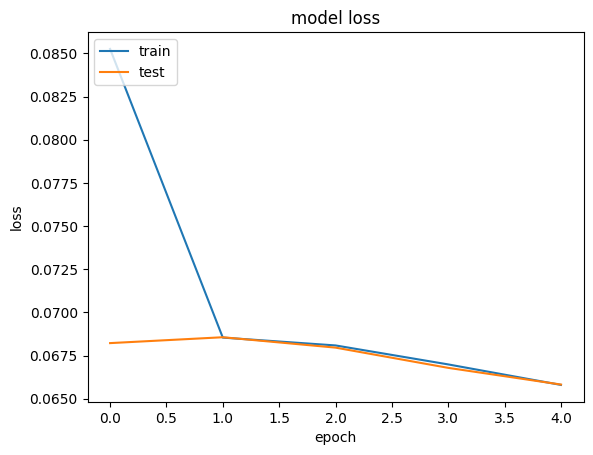

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [35]:
# Let us get a user and see the top recommendations.
user_id = users_df.steam_id.sample(1).iloc[0]
games_played_by_user = users_df[users_df.steam_id == user_id]
games_not_played = game_df[
    ~game_df["appid"].isin(games_played_by_user.appid.values)
]["appid"]
games_not_played = list(
    set(games_not_played).intersection(set(game2game_encoded.keys()))
)
games_not_played = [[game2game_encoded.get(x)] for x in games_not_played]
user_encoder = user2user_encoded.get(user_id)
user_game_array = np.hstack(
    ([[user_encoder]] * len(games_not_played), games_not_played)
)
playtimes = model.predict(user_game_array).flatten()
top_playtimes_indices = playtimes.argsort()[-10:][::-1]
recommended_game_ids = [
    game_encoded2game.get(games_not_played[x][0]) for x in top_playtimes_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("games with high playtimes from user")
print("----" * 8)
top_games_user = (
    games_played_by_user.sort_values(by="playtime_forever", ascending=False)
    .head(5)
    .appid.values
)
game_df_rows = game_df[game_df["appid"].isin(top_games_user)]
for row in game_df_rows.itertuples():
    print(row.name)

print("----" * 8)
print("Top 10 game recommendations")
print("----" * 8)
recommended_games = game_df[game_df["appid"].isin(recommended_game_ids)]
for row in recommended_games.itertuples():
    print(row.name)


612/612 [==============================] - 0s 736us/step
Showing recommendations for user: 76561198149033051
games with high playtimes from user
--------------------------------
Garry's Mod
Rocket League®
Among Us
The Binding of Isaac: Rebirth
Cookie Clicker
--------------------------------
Top 10 game recommendations
--------------------------------
PUBG: BATTLEGROUNDS
Europa Universalis IV
FINAL FANTASY XIV Online
NGU IDLE
XSOverlay
Football Manager 2021
Football Manager 2017
Stream Avatars
Bullet Life 2010
Football Manager 2023
